In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
df = pd.read_csv('/Users/henry/Downloads/movie_metadata.csv', sep=',', quotechar='"')
df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [3]:
df.shape

(5043, 28)

In [4]:
# let's get an idea what content_rating is
df['content_rating'].head()

0    PG-13
1    PG-13
2    PG-13
3    PG-13
4      NaN
Name: content_rating, dtype: object

In [5]:
df = df.reindex(np.random.permutation(df.index))

In [6]:
# just sanity-checking that the shape hasn't changed after randomization
df.shape

(5043, 28)

In [7]:
df.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')

In [8]:
# data cleaning
def inf_to_nan(series):
    return series.replace([np.inf, -np.inf], np.nan)

def drop_na_rows(df, columns):
    """
    remove those rows in df which has nan in one of the columns
    """
    return df.dropna(axis=0, how='any', subset=columns)

In [9]:
# I need a legitimate title_year to take inflation into account
df['title_year'] = inf_to_nan(df['title_year'])
clean_df = drop_na_rows(df, ['title_year'])
assert clean_df.shape[0] < 5000
clean_df.shape[0]

4935

In [10]:
# as mentioned in Important notes, point #6, some gross are denominated in other currencies
# to keep things simple, let's focus on American films => left with 3733 rows

clean_df = clean_df[df.country == 'USA']
clean_df.shape

/Users/henry/.pyenv/versions/3.6.2/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


(3733, 28)

In [11]:
# as mentioned in Important notes, point #3, there are around 800 "0"s in the "gross" attribute, remove those rows

clean_df = clean_df[df.gross > 0]
clean_df.shape

/Users/henry/.pyenv/versions/3.6.2/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


(3235, 28)

In [12]:
clean_df['title_year'].describe()

count    3235.000000
mean     2003.169706
std         9.935037
min      1920.000000
25%      1999.000000
50%      2005.000000
75%      2010.000000
max      2016.000000
Name: title_year, dtype: float64

In [13]:
clean_df['gross'].describe()

count    3.235000e+03
mean     5.521461e+07
std      7.173312e+07
min      7.030000e+02
25%      1.011027e+07
50%      3.217878e+07
75%      7.214700e+07
max      7.605058e+08
Name: gross, dtype: float64

In [14]:
# normalize gross, i.e. bring all gross revenue to 2016 assuming 4% annual inflation since 1920
# the reality is more complicated https://inflationdata.com/Inflation/Inflation_Rate/Long_Term_Inflation.asp
# but I have to start somewhere... i.e. 4%

clean_df['adjusted_profit'] = (clean_df['gross'] - clean_df['budget']) * 1.04**(2016 - clean_df['title_year'])
clean_df['adjusted_profit'].describe()

count    3.074000e+03
mean     4.048499e+07
std      1.645230e+08
min     -2.631049e+08
25%     -1.379435e+07
50%      5.558011e+06
75%      4.994008e+07
max      4.054227e+09
Name: adjusted_profit, dtype: float64

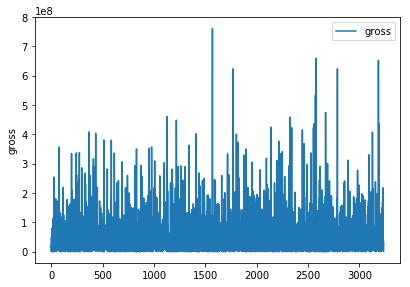

In [15]:
plt.ylabel("gross")
plt.xlabel("")
plt.title("")
plt.tight_layout()
plt.plot(list(clean_df['gross']), label="gross")
plt.legend()
plt.show()

In [16]:
sorted = clean_df.sort_values(by='adjusted_profit', ascending=False, axis=0).loc[:,['gross', 'adjusted_profit',
       'movie_title', 'plot_keywords', 'language', 'country', 'budget', 'title_year', 'imdb_score']]
sorted.head(15)

,gross,adjusted_profit,movie_title,plot_keywords,language,country,budget,title_year,imdb_score
4449,184925485.0,4.054227e+09,Snow White and the Seven Dwarfs,dwarf|love|princess|queen|snow white,English,USA,2000000.0,1937.0,7.7
3970,198655278.0,3.989189e+09,Gone with the Wind,battle of the sexes|gallantry|honesty|indiffer...,English,USA,3977000.0,1939.0,8.2
3024,460935665.0,2.077068e+09,Star Wars: Episode IV - A New Hope,death star|empire|galactic war|princess|rebellion,English,USA,11000000.0,1977.0,8.7
3080,434949459.0,1.610496e+09,E.T. the Extra-Terrestrial,bicyclist|boy|doll|star wars reference|voice i...,English,USA,10500000.0,1982.0,7.9
1143,84300000.0,1.609740e+09,Pinocchio,boy|conscience|fairy|jiminy cricket|pinocchio,English,USA,2600000.0,1940.0,7.5
4225,76400000.0,1.460391e+09,Fantasia,apprentice|classical music|disney|mouse|orchestra,English,USA,2280000.0,1940.0,7.8
2917,260000000.0,1.258251e+09,Jaws,beach|blockbuster|fishing|great white shark|shark,English,USA,8000000.0,1975.0,8.0
3359,163214286.0,1.145703e+09,The Sound of Music,austria|children|governess|love|orchestral mus...,English,USA,8200000.0,1965.0,8.0
2051,290158751.0,1.116921e+09,Star Wars: Episode V - The Empire Strikes Back,duel|famous twist|rebel|rescue|snowy landscape,English,USA,18000000.0,1980.0,8.8
2916,204565000.0,1.061548e+09,The Exorcist,demonic possession|exorcism|exorcist|loss of i...,English,USA,8000000.0,1973.0,8.0


In [17]:
clean_df.shape

(3235, 29)

In [18]:
correlation_df = clean_df.copy()
correlation_df.corr()['adjusted_profit'].sort_values()

title_year                  -0.375180
aspect_ratio                -0.086631
facenumber_in_poster        -0.031801
budget                      -0.031506
actor_1_facebook_likes       0.006957
cast_total_facebook_likes    0.025583
actor_2_facebook_likes       0.033938
actor_3_facebook_likes       0.057017
director_facebook_likes      0.082494
movie_facebook_likes         0.086606
num_critic_for_reviews       0.092278
duration                     0.140801
num_user_for_reviews         0.234989
imdb_score                   0.259685
num_voted_users              0.335221
gross                        0.515573
adjusted_profit              1.000000
Name: adjusted_profit, dtype: float64

In [19]:
def preprocess_features(input_df):
    """Prepares input features from data set.
    Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
    """
    selected_features = input_df[['color', 'director_name', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'genres', 'actor_1_name',
       'movie_title', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'language', 'content_rating', 'title_year', 'actor_2_facebook_likes', 'aspect_ratio']]
    processed_features = selected_features.copy()
    
    # Create a synthetic feature?
    
    return processed_features


def preprocess_targets(input_df):
    """Prepares target features (i.e., labels)
    Returns:
    A DataFrame that contains the target feature.
    """
    output_targets = pd.DataFrame()
    # Scale the target to be in units of millions of dollars.
    output_targets["adjusted_profit"] = (input_df["adjusted_profit"] / 1000000.0)
    return output_targets

In [20]:
clean_df.shape

# will split into 2000 and 1235 rows for training and validation

(3235, 29)

In [29]:
clean_df = clean_df.reindex(np.random.permutation(clean_df.index))
training_examples = preprocess_features(clean_df.iloc[0:2000,:])
validation_examples = preprocess_features(clean_df.iloc[2000:,:])
training_examples.describe()

,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,cast_total_facebook_likes,facenumber_in_poster,title_year,actor_2_facebook_likes,aspect_ratio
count,1999.000000,2000.000000,1996.000000,1998.000000,2000.000000,1997.000000,2000.000000,1998.000000,1950.000000
mean,108.545773,814.687500,814.127756,8342.053053,12396.955500,1.438658,2003.065500,2202.724224,2.090646
std,21.551479,3149.198783,1911.929472,19247.284212,22731.260537,2.217590,10.185091,5145.349454,0.418827
min,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1920.000000,0.000000,1.180000
25%,95.000000,10.000000,232.000000,799.500000,2194.250000,0.000000,1999.000000,434.000000,1.850000
50%,104.000000,57.000000,465.000000,2000.000000,4496.500000,1.000000,2005.000000,725.000000,1.850000
75%,118.000000,217.250000,716.250000,13000.000000,16543.500000,2.000000,2010.000000,988.000000,2.350000
max,325.000000,23000.000000,23000.000000,640000.000000,656730.000000,43.000000,2016.000000,137000.000000,16.000000


In [30]:
validation_examples.describe()

,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,cast_total_facebook_likes,facenumber_in_poster,title_year,actor_2_facebook_likes,aspect_ratio
count,1235.000000,1235.000000,1232.000000,1235.000000,1235.000000,1232.000000,1235.000000,1234.000000,1209.000000
mean,109.485830,967.924696,797.873377,7412.704453,11218.779757,1.366883,2003.338462,1933.944084,2.105666
std,22.382387,3443.167735,2000.617383,10288.646756,14636.627842,1.965207,9.517812,3862.231387,0.269296
min,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1933.000000,0.000000,1.330000
25%,95.000000,10.000000,213.000000,767.000000,2022.000000,0.000000,1999.000000,405.000000,1.850000
50%,106.000000,63.000000,455.000000,1000.000000,3956.000000,1.000000,2005.000000,692.000000,2.350000
75%,119.000000,248.500000,713.500000,12000.000000,16071.000000,2.000000,2010.000000,979.000000,2.350000
max,330.000000,22000.000000,23000.000000,87000.000000,106759.000000,19.000000,2016.000000,25000.000000,2.760000


In [31]:
training_targets = preprocess_targets(clean_df.iloc[0:2000,:])
validation_targets = preprocess_targets(clean_df.iloc[2000:,:])
training_targets.describe()

,adjusted_profit
count,1904.000000
mean,44.298551
std,183.243131
min,-263.104948
25%,-13.816375
50%,5.891517
75%,54.733265
max,4054.226610


In [32]:
validation_targets.describe()

,adjusted_profit
count,1170.000000
mean,34.278983
std,128.182604
min,-235.823008
25%,-13.708128
50%,4.805861
75%,44.630752
max,2077.067701


In [35]:
def train_model(
    target,
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    """Trains a linear regression model.

    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.

    Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.

    Returns:
    A `LinearRegressor` object trained on the training data.
    """

    periods = 10
    steps_per_period = steps / periods

    # Create a linear regressor object.
    feature_columns = set([tf.contrib.layers.real_valued_column(my_feature) for my_feature in training_examples])
    linear_regressor = tf.contrib.learn.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate),
      gradient_clip_norm=5.0
    )

    # Create input functions
    training_input_fn = learn_io.pandas_input_fn(
      x=training_examples, y=training_targets[target],
      num_epochs=None, batch_size=batch_size)
    predict_training_input_fn = learn_io.pandas_input_fn(
      x=training_examples, y=training_targets[target],
      num_epochs=1, shuffle=False)
    predict_validation_input_fn = learn_io.pandas_input_fn(
      x=validation_examples, y=validation_targets[target],
      num_epochs=1, shuffle=False)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        linear_regressor.fit(
            input_fn=training_input_fn,
            steps=steps_per_period,
        )
        # Take a break and compute predictions.
        training_predictions = list(linear_regressor.predict(input_fn=predict_training_input_fn))
        validation_predictions = list(linear_regressor.predict(input_fn=predict_validation_input_fn))
        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets))
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")


    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    return linear_regressor

In [38]:
from tensorflow.contrib.learn.python.learn import learn_io

train_model(
    target='adjusted_profit',
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x115c4ab70>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/var/folders/4r/9x2x9y0944z71__p8xf3r9y80000gn/T/tmprz58msdo'}
Training model...
RMSE (on training data):
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created 

SystemError: <built-in function TF_Run> returned a result with an error set